#  **Dataset Loading and Preprocessing**

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler

sns.set_style('darkgrid')


Loading Dataset

In [2]:
# Mount Google Drive if running in Colab
from google.colab import drive
drive.mount('/content/drive')

# Define dataset path and load into DataFrame
load_path = '/content/drive/MyDrive/datasets/sensor.csv'
#load_path = '/content/drive/MyDrive/datasets/pump-sensor-data/sensor.csv'


data = pd.read_csv(load_path)
print(data.head())

# if not already in the drive:

import shutil
import os

drive_path = '/content/drive/MyDrive/datasets/pump-sensor-data'
os.makedirs(drive_path, exist_ok=True)
local_file = os.path.join(drive_path, 'sensor.csv')

if not os.path.exists(local_file):
    import kagglehub
    path = kagglehub.dataset_download("nphantawee/pump-sensor-data")
    shutil.copy(os.path.join(path, 'sensor.csv'), local_file)


Mounted at /content/drive
   Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0           0  2018-04-01 00:00:00   2.465394   47.09201    53.2118   
1           1  2018-04-01 00:01:00   2.465394   47.09201    53.2118   
2           2  2018-04-01 00:02:00   2.444734   47.35243    53.2118   
3           3  2018-04-01 00:03:00   2.460474   47.09201    53.1684   
4           4  2018-04-01 00:04:00   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65.6

Preprocessing

In [3]:
# Convert timestamp column to pandas datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Find all timestamps where the machine was BROKEN
broken_timestamps = data[data["machine_status"] == "BROKEN"]["timestamp"].reset_index(drop=True)

# Show how often each status appears in the dataset
print("\nMachine status distribution:\n")
status_counts = data['machine_status'].value_counts()
for status, count in status_counts.items():
    print(f"  {status:<10} : {count:,}")

print("\nFailure (BROKEN) events detected at these timestamps:\n")
for idx, ts in enumerate(broken_timestamps, 1):
    print(f"  {idx}. {pd.to_datetime(ts).strftime('%Y-%m-%d %H:%M:%S')}")



Machine status distribution:

  NORMAL     : 205,836
  RECOVERING : 14,477
  BROKEN     : 7

Failure (BROKEN) events detected at these timestamps:

  1. 2018-04-12 21:55:00
  2. 2018-04-18 00:30:00
  3. 2018-05-19 03:18:00
  4. 2018-05-25 00:30:00
  5. 2018-06-28 22:00:00
  6. 2018-07-08 00:11:00
  7. 2018-07-25 14:00:00


In [4]:
# For every failure, grab sensor data 1 day before and after
time_window = pd.Timedelta(days=1)
broken_windows = []

for broken_time in broken_timestamps:
    mask = (data["timestamp"] >= (broken_time - time_window)) & (data["timestamp"] <= (broken_time + time_window))
    broken_windows.append(data[mask])

# Combine all failure windows into one DataFrame
df_broken_window = pd.concat(broken_windows).reset_index(drop=True)
print(df_broken_window.head())

   Unnamed: 0           timestamp  sensor_00  sensor_01  sensor_02  sensor_03  \
0       15715 2018-04-11 21:55:00   2.453588   51.25868  52.821178  42.751736   
1       15716 2018-04-11 21:56:00   2.456539   51.25868  52.821178  42.751740   
2       15717 2018-04-11 21:57:00   2.451620   51.30208  52.821180  42.708330   
3       15718 2018-04-11 21:58:00   2.456539   51.38889  52.951390  42.708332   
4       15719 2018-04-11 21:59:00   2.453588   51.25868  52.907990  42.708332   

   sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  sensor_44  \
0   660.8796   70.43793   13.64294   16.16753  ...   44.53125   56.42361   
1   637.9630   70.47101   13.55613   16.21094  ...   44.01041   58.15972   
2   637.1528   69.82243   13.61400   16.16753  ...   43.22916   61.92130   
3   637.9630   70.76299   13.59230   16.16753  ...   42.18750   63.94676   
4   646.4120   71.20968   13.59230   16.16753  ...   41.92708   64.23611   

   sensor_45  sensor_46  sensor_47  sensor_48  sensor_49

#  **Feature Selection**

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

try:
    import eli5
    from eli5.sklearn import PermutationImportance
    eli5_installed = True
except ImportError:
    eli5_installed = False

# Start with a fresh copy to avoid changing the original data
df = data.copy()

drop_cols = ['Unnamed: 0', 'timestamp']
for col in drop_cols:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# Convert machine status to binary: 1 for failure or recovering, 0 for normal
df['target'] = df['machine_status'].map(lambda x: 1 if x != 'NORMAL' else 0)
df.drop('machine_status', axis=1, inplace=True)

# Remove columns that are not sensor readings if any
sensor_cols = [col for col in df.columns if col.startswith('sensor_')]
X = df[sensor_cols]
y = df['target']

# Train-test split for feature ranking
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Normalize the sensor data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a RandomForest classifier for feature importance
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)

# Show the 10 most important sensors based on RandomForest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort descending
print("\n[RandomForest] Top 10 most important sensors:")
for i in range(10):
    print(f"{sensor_cols[indices[i]]}: {importances[indices[i]]:.4f}")

# permutation importance for more robust feature ranking
if eli5_installed:
    perm = PermutationImportance(rf, random_state=42).fit(X_test_scaled, y_test)
    sorted_idx = perm.feature_importances_.argsort()[::-1]
    print("\n[Permutation Importance] Top 10 sensors:")
    for i in range(10):
        print(f"{sensor_cols[sorted_idx[i]]}: {perm.feature_importances_[sorted_idx[i]]:.4f} ± {perm.feature_importances_std_[sorted_idx[i]]:.4f}")
else:
    print("eli5 not installed, skipping permutation importance.")

# Select the top N features for anomaly detection (set N based on importance)
N = 5
top_features = [sensor_cols[indices[i]] for i in range(N)]
print(f"\nSelected sensors for anomaly detection: {top_features}")

X_selected = df[top_features]
print("\nSample of selected features data:")
print(X_selected.head())

# top features are:
# sensor0 = motor vibration
# sensor4 = motor speed
# sensor6 = motor active power
# sensor11 = motor phase current A
# sensor12 = motor phase current B
# sensor5 = motor current



/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))



[RandomForest] Top 10 most important sensors:
sensor_00: 0.1511
sensor_12: 0.1349
sensor_04: 0.1219
sensor_11: 0.0865
sensor_06: 0.0829
sensor_10: 0.0756
sensor_50: 0.0670
sensor_13: 0.0438
sensor_48: 0.0393
sensor_02: 0.0314
eli5 not installed, skipping permutation importance.

Selected sensors for anomaly detection: ['sensor_00', 'sensor_12', 'sensor_04', 'sensor_11', 'sensor_06']

Sample of selected features data:
   sensor_00  sensor_12  sensor_04  sensor_11  sensor_06
0   2.465394   31.11716   634.3750   47.52422   13.41146
1   2.465394   31.11716   634.3750   47.52422   13.41146
2   2.444734   32.08894   638.8889   48.17723   13.32465
3   2.460474   31.67221   628.1250   48.65607   13.31742
4   2.445718   31.95202   636.4583   49.06298   13.35359


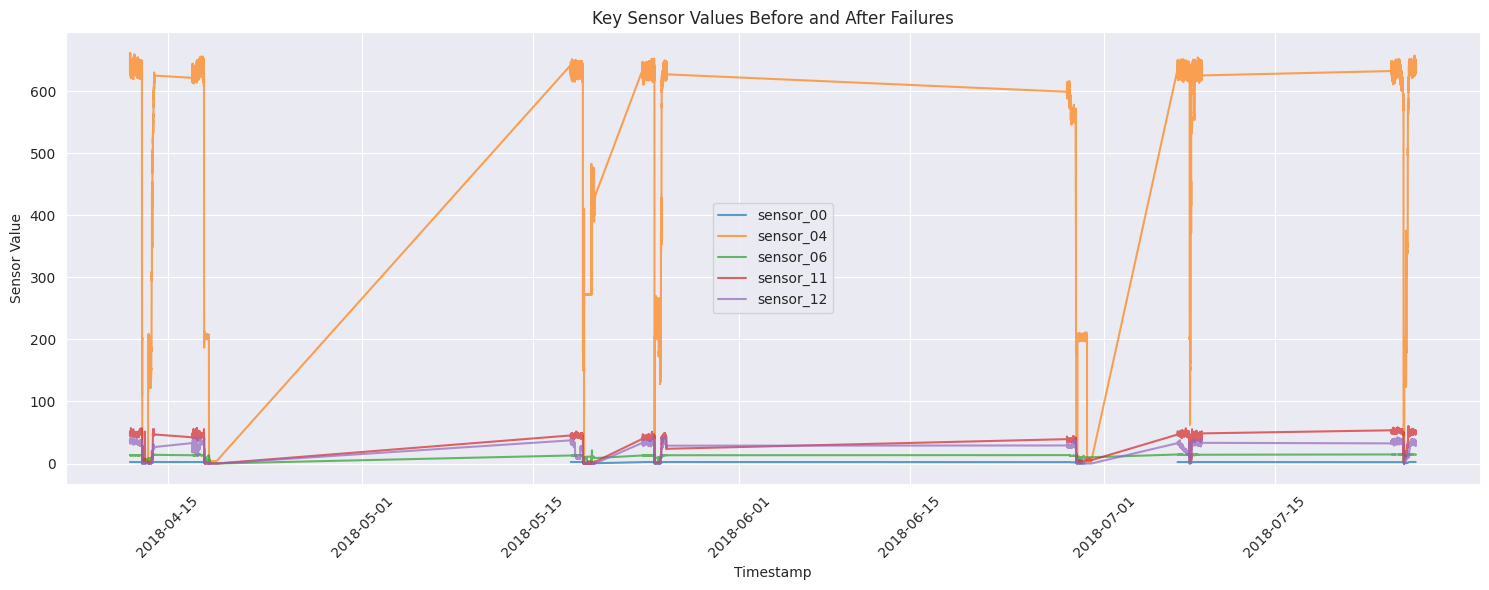

In [6]:
#Plot a few key sensors around failure events
selected_sensors = ["sensor_00", "sensor_04", "sensor_06", "sensor_11", "sensor_12"]

plt.figure(figsize=(15, 6))
for sensor in selected_sensors:
    plt.plot(df_broken_window['timestamp'], df_broken_window[sensor], label=sensor, alpha=0.7)

plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")
plt.title("Key Sensor Values Before and After Failures")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


#  **Anomaly Detection**

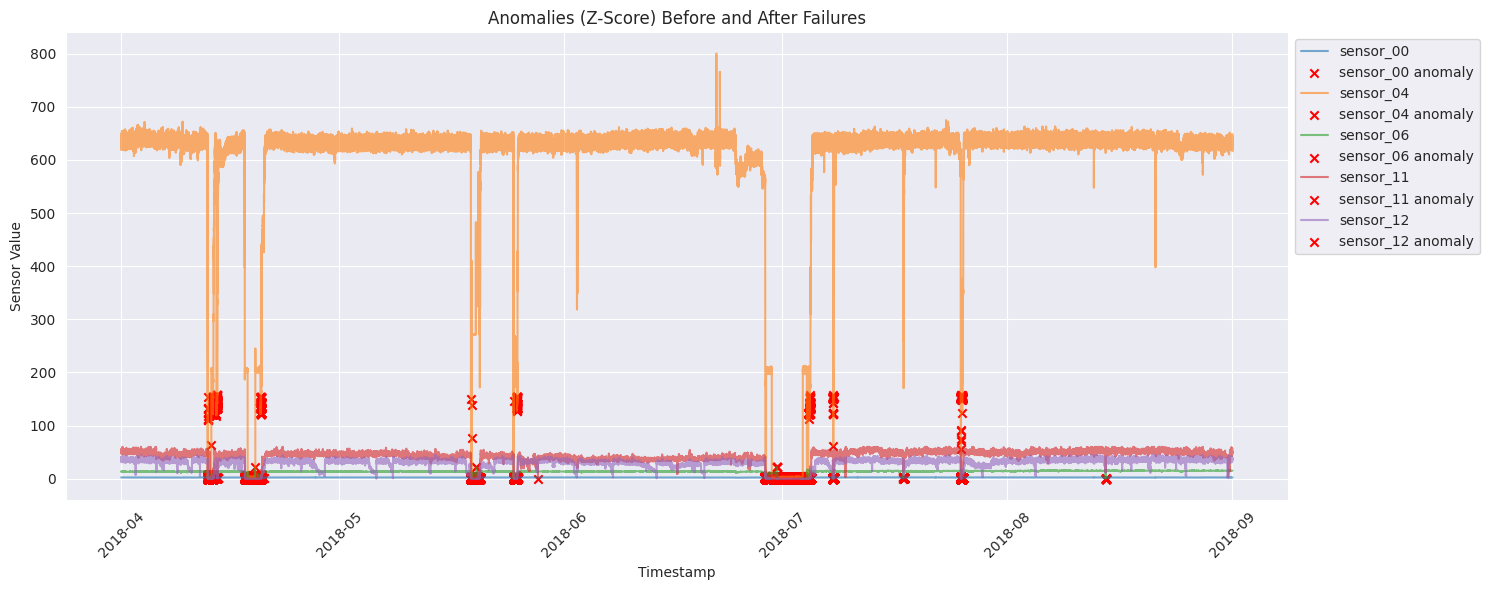

In [7]:
# Z-score anomaly detection function
def detect_anomalies_zscore(series, threshold=3):
    mean_val = series.mean()
    std_val = series.std()
    z_scores = (series - mean_val) / std_val
    return np.abs(z_scores) > threshold

# Apply to each selected sensor
anomaly_flags = {}
for sensor in selected_sensors:
    anomaly_flags[sensor] = detect_anomalies_zscore(data[sensor])

# Plot sensor values and highlight anomalies
plt.figure(figsize=(15, 6))
for sensor in selected_sensors:
    plt.plot(data['timestamp'], data[sensor], label=sensor, alpha=0.6)
    plt.scatter(data['timestamp'][anomaly_flags[sensor]],
                data[sensor][anomaly_flags[sensor]], color='red', marker='x', label=f'{sensor} anomaly')
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")
plt.title("Anomalies (Z-Score) Before and After Failures")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


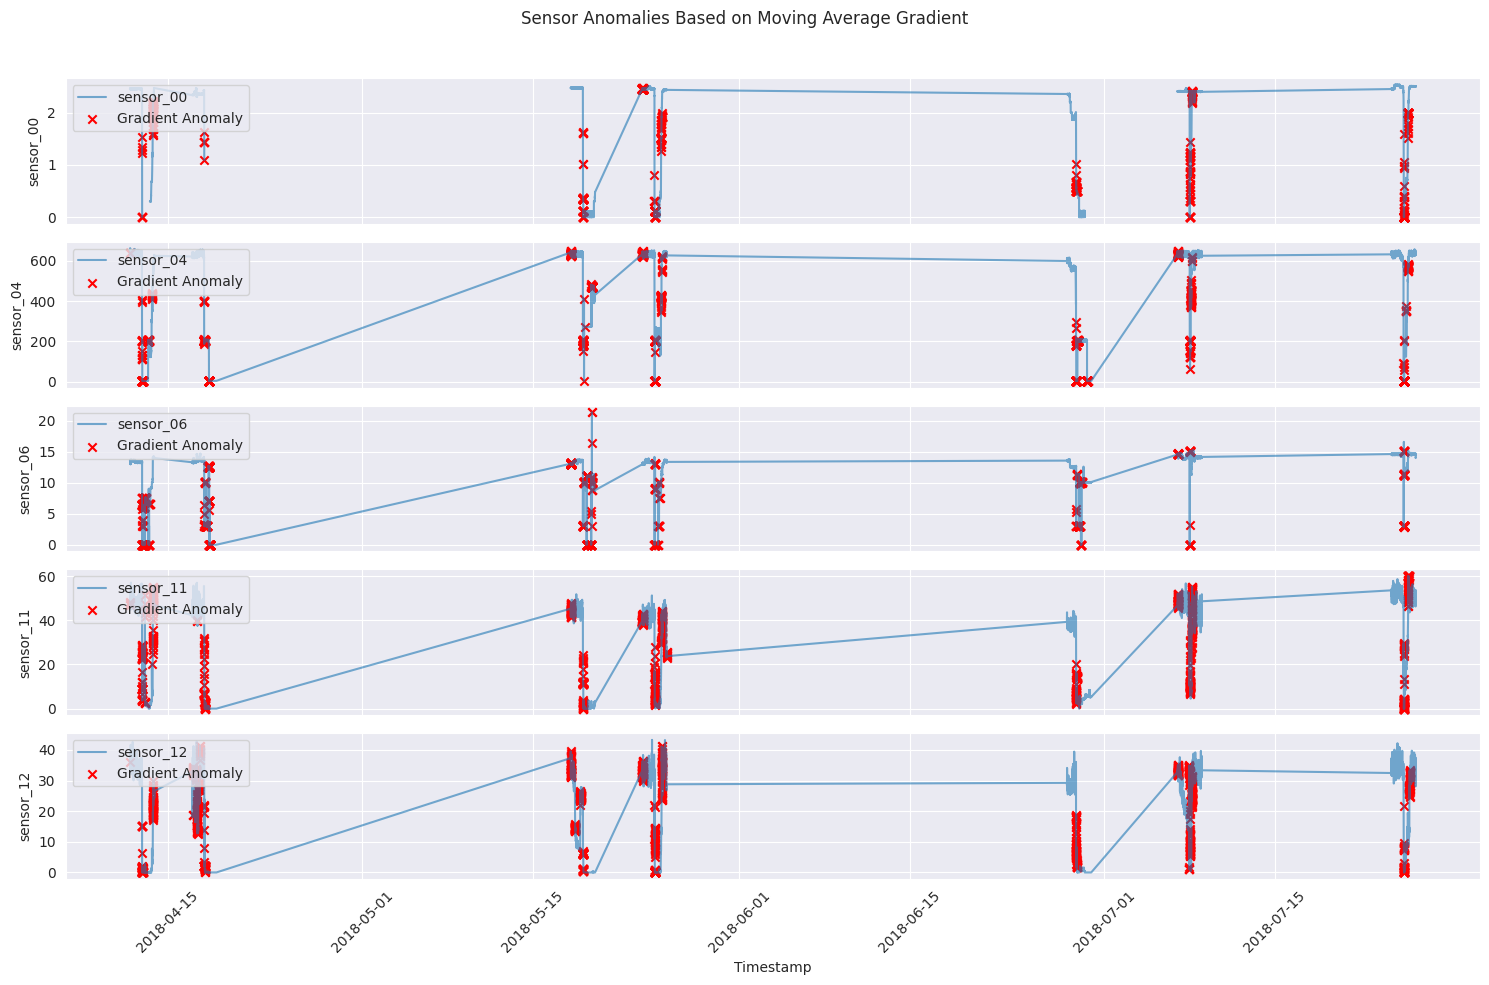

In [8]:
# Moving average and gradient calculation for each sensor
window_size = 60   # Adjust based on your sampling rate

for sensor in selected_sensors:
    df_broken_window[f"{sensor}_ma"] = df_broken_window[sensor].rolling(window=window_size, min_periods=1).mean()
    df_broken_window[f"{sensor}_grad"] = df_broken_window[f"{sensor}_ma"].diff()

# Adaptive threshold for gradient anomaly detection
threshold_factor = 2  # 2x standard deviation
adaptive_thresholds = {}
for sensor in selected_sensors:
    grad_std = df_broken_window[f"{sensor}_grad"].std()
    adaptive_thresholds[sensor] = threshold_factor * grad_std

# Detect gradient-based anomalies per sensor
gradient_anomaly_flags = {}
for sensor in selected_sensors:
    gradient_anomaly_flags[sensor] = np.abs(df_broken_window[f"{sensor}_grad"]) > adaptive_thresholds[sensor]

# Visualize anomalies based on gradient
fig, axes = plt.subplots(len(selected_sensors), 1, figsize=(15, 10), sharex=True)
for i, sensor in enumerate(selected_sensors):
    axes[i].plot(df_broken_window['timestamp'], df_broken_window[sensor], label=sensor, alpha=0.6)
    axes[i].scatter(df_broken_window['timestamp'][gradient_anomaly_flags[sensor]],
                    df_broken_window[sensor][gradient_anomaly_flags[sensor]],
                    color='red', marker='x', label='Gradient Anomaly')
    axes[i].set_ylabel(sensor)
    axes[i].legend(loc='upper left')
    axes[i].grid(True)
axes[-1].set_xlabel("Timestamp")
plt.suptitle("Sensor Anomalies Based on Moving Average Gradient")
plt.xticks(rotation=45)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


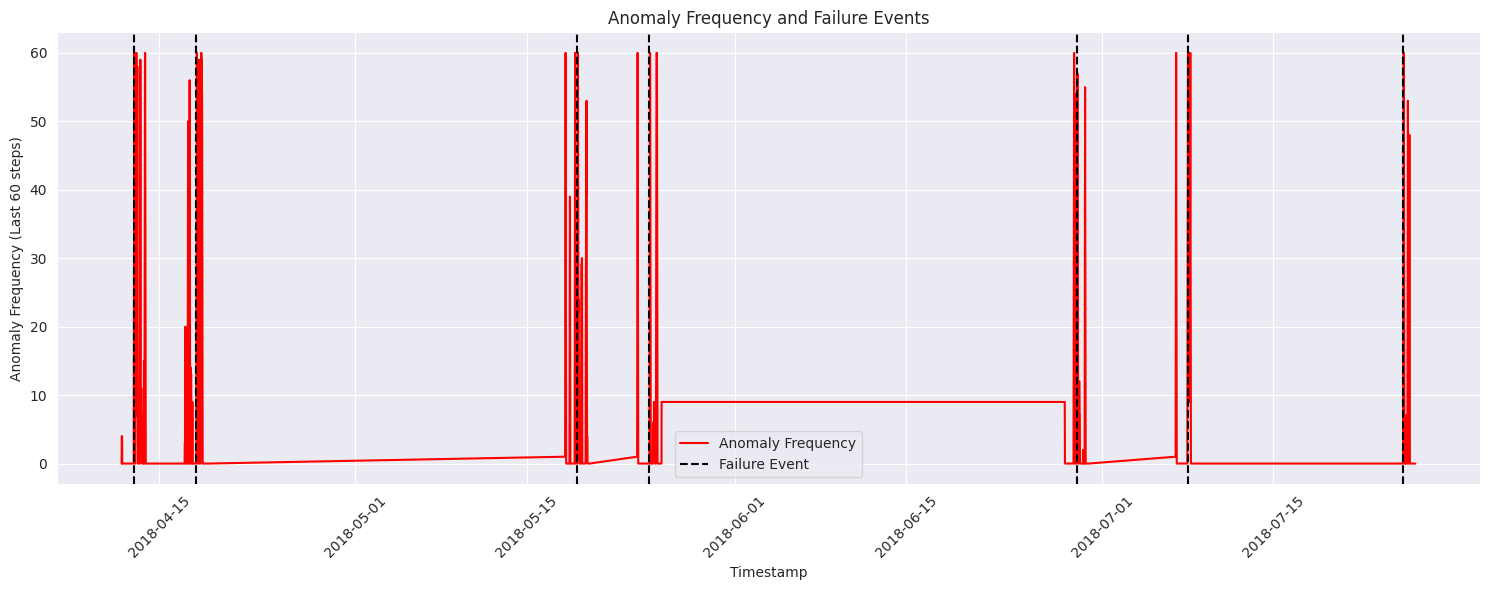

In [46]:
# Count anomalous at each timestamp
anomaly_count = np.zeros(len(df_broken_window))
for sensor in selected_sensors:
    anomaly_count += gradient_anomaly_flags[sensor].astype(int)
df_broken_window['anomaly_count'] = anomaly_count

# Mark as global anomaly if >=1 sensors are anomalous
anomaly_threshold = 1 #sensors
df_broken_window['overall_anomaly'] = df_broken_window['anomaly_count'] >= anomaly_threshold

# Rolling sum: how many overall anomalies in the last 60 timesteps
rolling_window = 60
df_broken_window['anomaly_frequency'] = df_broken_window['overall_anomaly'].rolling(window=rolling_window, min_periods=1).sum()

plt.figure(figsize=(15, 6))
plt.plot(df_broken_window['timestamp'], df_broken_window['anomaly_frequency'], color='red', label="Anomaly Frequency")
for broken_time in broken_timestamps:
    plt.axvline(x=broken_time, color='black', linestyle='--', label="Failure Event" if broken_time==broken_timestamps.iloc[0] else "")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly Frequency (Last 60 steps)")
plt.title("Anomaly Frequency and Failure Events")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()




In [43]:
# Systematically try different thresholds to balance early warning and false alarms
# the value of threshold defines the time before the falure we want to get notified
threshold_range = range(1, 16)
evaluation_results = []

for threshold in threshold_range:
    df_broken_window["failure_warning"] = df_broken_window["anomaly_frequency"] > threshold
    true_positives = 0
    false_positives = 0
    for broken_time in broken_timestamps:
        warning_window = df_broken_window[
            (df_broken_window["timestamp"] >= broken_time - pd.Timedelta(hours=1)) &
            (df_broken_window["timestamp"] < broken_time)
        ]
        if warning_window["failure_warning"].any():
            true_positives += 1
        else:
            false_positives += 1
    evaluation_results.append({"Threshold": threshold, "True Positives": true_positives, "False Positives": false_positives})

df_evaluation = pd.DataFrame(evaluation_results)
print(df_evaluation)


    Threshold  True Positives  False Positives
0           1               4                3
1           2               4                3
2           3               4                3
3           4               4                3
4           5               3                4
5           6               3                4
6           7               3                4
7           8               3                4
8           9               3                4
9          10               0                7
10         11               0                7
11         12               0                7
12         13               0                7
13         14               0                7
14         15               0                7


In [44]:
# Select threshold that gives maximum true positives with minimal false positives
optimal_threshold_candidates = df_evaluation[df_evaluation["False Positives"] <= 5]
if not optimal_threshold_candidates.empty:
    optimal_threshold = optimal_threshold_candidates.sort_values(by="True Positives", ascending=False).head(1)["Threshold"].values[0]
else:
    optimal_threshold = df_evaluation.sort_values(by="False Positives", ascending=True).head(1)["Threshold"].values[0]

# Apply the optimal threshold
df_broken_window["failure_warning"] = df_broken_window["anomaly_frequency"] > optimal_threshold
print("Optimal threshold for failure warning:", optimal_threshold)


Optimal threshold for failure warning: 1


In [45]:
# See where warnings are triggered just before a real failure event
print("Early warnings triggered before failures:")
for broken_time in broken_timestamps:
    warning_window = df_broken_window[
        (df_broken_window["timestamp"] >= broken_time - pd.Timedelta(hours=1)) &
        (df_broken_window["timestamp"] < broken_time)
    ]
    warning_times = warning_window[warning_window["failure_warning"] == True]["timestamp"].values
    print(f"\nFailure at {broken_time}:")
    if len(warning_times) > 0:
        print(f"  Warning(s) triggered at: {warning_times}")
    else:
        print("  No warning triggered before this failure.")


Early warnings triggered before failures:

Failure at 2018-04-12 21:55:00:
  Warning(s) triggered at: ['2018-04-12T21:44:00.000000000' '2018-04-12T21:45:00.000000000'
 '2018-04-12T21:46:00.000000000' '2018-04-12T21:47:00.000000000'
 '2018-04-12T21:48:00.000000000' '2018-04-12T21:49:00.000000000'
 '2018-04-12T21:50:00.000000000' '2018-04-12T21:51:00.000000000'
 '2018-04-12T21:52:00.000000000' '2018-04-12T21:53:00.000000000'
 '2018-04-12T21:54:00.000000000']

Failure at 2018-04-18 00:30:00:
  Warning(s) triggered at: ['2018-04-18T00:12:00.000000000' '2018-04-18T00:13:00.000000000'
 '2018-04-18T00:14:00.000000000' '2018-04-18T00:15:00.000000000'
 '2018-04-18T00:16:00.000000000' '2018-04-18T00:17:00.000000000'
 '2018-04-18T00:18:00.000000000' '2018-04-18T00:19:00.000000000'
 '2018-04-18T00:20:00.000000000' '2018-04-18T00:21:00.000000000'
 '2018-04-18T00:22:00.000000000' '2018-04-18T00:23:00.000000000'
 '2018-04-18T00:24:00.000000000' '2018-04-18T00:25:00.000000000'
 '2018-04-18T00:26:00.00


=== Mahalanobis (Empirical) — top rows ===
   Percentile  ThresholdValue  Failures  TP_events  FN_events  Warning_Onsets  \
0        70.0         143.727         7          5          2              84   
1        80.0         197.366         7          4          3              26   
2        75.0         157.882         7          4          3              41   
3        85.0         603.470         7          2          5              42   
4        99.5        1574.738         7          0          7               5   
5        90.0        1269.883         7          0          7               7   
6        92.5        1291.429         7          0          7              11   
7        95.0        1309.269         7          0          7              21   

   TP_preds  FP  Precision  Recall     F1  Mean_Lead_Min  Median_Lead_Min  \
0         5  79      0.060   0.714  0.110            1.0              1.0   
1         4  22      0.154   0.571  0.242            1.0              1.

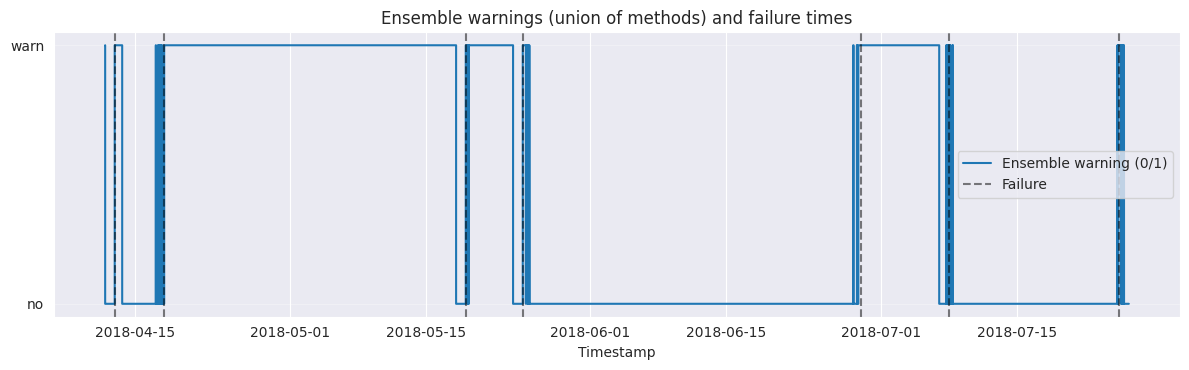

In [23]:
# Ensemble anomaly detection
# Methods: Mahalanobis (Empirical), PCA (T² + SPE), LOF (novelty)
# Policy: perfect-recall-first. If a method can reach FN=0, we pick the
#         lowest-FP/day threshold among those; otherwise we pick the
#         recall-first row. The ensemble uses a union rule (OR).


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EmpiricalCovariance
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


use_features   = ["sensor_00", "sensor_04", "sensor_06", "sensor_11", "sensor_12"]
horizon        = pd.Timedelta(hours=1)               # warning counts if within this lookback before failure
buffer_hours   = 6                                    # keep training NORMAL data far from failures
percentiles    = [70, 75, 80, 85, 90, 92.5, 95, 97.5, 99, 99.5]
rolling_smooth = 5                                    # minor smoothing of score series (in steps)



data["timestamp"] = pd.to_datetime(data["timestamp"])
df_broken_window["timestamp"] = pd.to_datetime(df_broken_window["timestamp"])
broken_timestamps = pd.to_datetime(broken_timestamps).sort_values().reset_index(drop=True)
df_broken_window = df_broken_window.sort_values("timestamp").copy()


def build_normal_train(df_all, failure_times, cols, buffer_hours=6):
    """
    pick a clean slice of NORMAL rows that are far from failures.
    this is the reference "healthy" set for fitting imputer/scaler and models.
    """
    df = df_all.copy()
    df = df.sort_values("timestamp")
    normal = df[df["machine_status"] == "NORMAL"].copy()

    keep = pd.Series(True, index=normal.index)
    for ft in pd.to_datetime(failure_times):
        left  = ft - pd.Timedelta(hours=buffer_hours)
        right = ft + pd.Timedelta(hours=buffer_hours)
        keep &= ~((normal["timestamp"] >= left) & (normal["timestamp"] <= right))

    clean = normal[keep]
    return clean[["timestamp"] + cols].sort_values("timestamp")

def evaluate_warning_series(warn_bool_series, failure_times, horizon):
    """
    event-aware evaluation for a boolean warning time series.
    returns a dict of metrics (TP_events, FN_events, precision/recall/F1, FP/day, lead times).
    """
    warn = warn_bool_series.sort_index().astype(bool)

    # failures as events
    caught, missed, leads = 0, 0, []
    for ft in pd.to_datetime(failure_times):
        window = warn.loc[(warn.index >= ft - horizon) & (warn.index < ft)]
        if len(window) and window.any():
            caught += 1
            last_warn_time = window[window].index.max()
            leads.append((ft - last_warn_time).total_seconds() / 60.0)
        else:
            missed += 1
    total_failures = int(len(failure_times))

    # predictions as events (count onsets)
    onset = warn & (~warn.shift(1, fill_value=False))
    onset_times = onset.index[onset]
    useful = 0
    for t0 in onset_times:
        has_fail = any((ft > t0) and (ft <= t0 + horizon) for ft in pd.to_datetime(failure_times))
        if has_fail:
            useful += 1
    fp = int(len(onset_times) - useful)

    # metrics
    recall    = (caught / total_failures) if total_failures > 0 else np.nan
    precision = (useful / len(onset_times)) if len(onset_times) > 0 else np.nan
    f1        = (2 * precision * recall / (precision + recall)) if (precision > 0 and recall > 0) else np.nan
    mean_lead = float(np.mean(leads)) if leads else np.nan
    med_lead  = float(np.median(leads)) if leads else np.nan
    span_days = (warn.index.max() - warn.index.min()).total_seconds() / (60*60*24)
    fp_per_day = fp / span_days if span_days > 0 else np.nan

    return {
        "Failures": total_failures,
        "TP_events": int(caught),
        "FN_events": int(missed),
        "Warning_Onsets": int(len(onset_times)),
        "TP_preds": int(useful),
        "FP": int(fp),
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Mean_Lead_Min": mean_lead,
        "Median_Lead_Min": med_lead,
        "FP_per_Day": fp_per_day
    }

def evaluate_score_series(score_series, failure_times, percentiles, horizon, rolling_smooth=5):
    """
    threshold a score series at several percentiles and evaluate each cutoff.
    returns (df_eval, best_row_by_policy, chosen_threshold_value).
    policy is perfect-recall-first; among FN=0 rows choose lowest FP/day,
    then higher precision, then longer median lead.
    """
    s = score_series.sort_index()
    if rolling_smooth and rolling_smooth > 1:
        s = s.rolling(rolling_smooth, min_periods=1).mean()

    th_values = {p: np.percentile(s.values, p) for p in percentiles}

    rows = []
    per_threshold_warn = {}  # cache warn series per threshold for reuse
    for p in percentiles:
        th = th_values[p]
        warn = s > th
        per_threshold_warn[p] = warn
        metrics = evaluate_warning_series(warn, failure_times, horizon)
        rows.append({
            "Percentile": p,
            "ThresholdValue": th,
            **metrics
        })

    df_eval = (pd.DataFrame(rows)
               .sort_values(["FN_events", "FP_per_Day", "Precision", "Median_Lead_Min"],
                            ascending=[True, True, False, False])
               .reset_index(drop=True))

    # pick by policy
    perfect = df_eval[df_eval["FN_events"] == 0]
    if not perfect.empty:
        best = perfect.sort_values(["FP_per_Day", "Precision", "Median_Lead_Min"],
                                   ascending=[True, False, False]).iloc[0]
    else:
        best = df_eval.iloc[0]

    chosen_p  = float(best["Percentile"])
    chosen_th = float(best["ThresholdValue"])
    chosen_warn = per_threshold_warn[chosen_p]

    return df_eval, best, chosen_th, chosen_warn

def make_series(name, arr, index):
    """tiny helper to turn a 1D array into a timestamp-indexed Series."""
    return pd.Series(np.asarray(arr).ravel(), index=pd.to_datetime(index), name=name)

# build training/evaluation matrices with imputation + scaling
# training on NORMAL far from failures (fit imputer/scaler on this to avoid leakage)
train_normal = build_normal_train(data, broken_timestamps, use_features, buffer_hours=buffer_hours)

# evaluation span = failure windows
eval_span = df_broken_window[["timestamp"] + use_features].copy().sort_values("timestamp")
eval_index = eval_span["timestamp"].values

# impute NaNs using medians learned from clean NORMAL data
imp = SimpleImputer(strategy="median")
X_train_imp = imp.fit_transform(train_normal[use_features])
X_eval_imp  = imp.transform(eval_span[use_features])

# standardize features (fit on train, apply to eval)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_imp)
X_eval_std  = scaler.transform(X_eval_imp)

# Mahalanobis (Empirical covariance)
# distance from multivariate normal fit to normal data; larger = more anomalous
mah = EmpiricalCovariance().fit(X_train_std)
mah_score = mah.mahalanobis(X_eval_std)
s_mah = make_series("Mahalanobis_Empirical", mah_score, eval_index)

mah_table, mah_best, mah_thr, mah_warn = evaluate_score_series(
    s_mah, broken_timestamps, percentiles, horizon, rolling_smooth
)
print("\n=== Mahalanobis (Empirical) — top rows ===")
print(mah_table.head(8).round(3))
print("\nBest (policy):", mah_best.to_dict())

# PCA (T² + SPE/Q combined)
# T² captures subspace excursion; SPE captures residual energy. sum their z-scores.
ncomp = min(3, X_train_std.shape[1])  # keep it small/robust
pca = PCA(n_components=ncomp).fit(X_train_std)
Z_eval  = pca.transform(X_eval_std)
lmbda   = np.maximum(pca.explained_variance_, 1e-12)

T2 = np.sum((Z_eval**2) / lmbda, axis=1)
X_eval_hat = pca.inverse_transform(Z_eval)
SPE = np.sum((X_eval_std - X_eval_hat)**2, axis=1)

def _z(a):
    a = np.asarray(a)
    sd = np.std(a)
    return (a - np.mean(a)) / (sd if sd > 0 else 1.0)

pca_score = _z(T2) + _z(SPE)
s_pca = make_series("PCA_T2_plus_SPE", pca_score, eval_index)

pca_table, pca_best, pca_thr, pca_warn = evaluate_score_series(
    s_pca, broken_timestamps, percentiles, horizon, rolling_smooth
)
print("\n=== PCA (T² + SPE) — top rows ===")
print(pca_table.head(8).round(3))
print("\nBest (policy):", pca_best.to_dict())

# LOF (novelty mode)
# density-based; flags points that look sparser than their neighbors
n_train = X_train_std.shape[0]
n_neighbors = max(10, min(50, n_train // 10))  # decent default tied to data volume
lof = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=True).fit(X_train_std)

# sklearn's LOF score_samples: larger = more normal; flip so larger = more anomalous
lof_score = -lof.score_samples(X_eval_std)
s_lof = make_series("LOF_novelty", lof_score, eval_index)

lof_table, lof_best, lof_thr, lof_warn = evaluate_score_series(
    s_lof, broken_timestamps, percentiles, horizon, rolling_smooth
)
print("\n=== LOF (novelty) — top rows ===")
print(lof_table.head(8).round(3))
print("\nBest (policy):", lof_best.to_dict())

# summarize per-method choices
per_method = []
for name, table, best, thr in [
    ("Mahalanobis_Empirical", mah_table, mah_best, mah_thr),
    ("PCA_T2_plus_SPE",      pca_table, pca_best, pca_thr),
    ("LOF_novelty",          lof_table, lof_best, lof_thr),
]:
    row = best.to_dict()
    row["Method"] = name
    row["Chosen_ThresholdValue"] = float(thr)
    per_method.append(row)

df_methods = (pd.DataFrame(per_method)
              .sort_values(["FN_events", "FP_per_Day", "Precision", "Median_Lead_Min"],
                           ascending=[True, True, False, False])
              .reset_index(drop=True))

print("\n=== Best per-method (policy ranking) ===")
with pd.option_context("display.max_columns", None, "display.width", 160):
    print(df_methods.round(3))

# combine the boolean warnings that correspond to the policy-chosen threshold for each method
warn_mah = mah_warn.astype(bool)
warn_pca = pca_warn.astype(bool)
warn_lof = lof_warn.astype(bool)

# align indices just in case (outer join then fill missing with False)
idx_union = warn_mah.index.union(warn_pca.index).union(warn_lof.index)
warn_mah = warn_mah.reindex(idx_union, fill_value=False)
warn_pca = warn_pca.reindex(idx_union, fill_value=False)
warn_lof = warn_lof.reindex(idx_union, fill_value=False)

warn_ensemble = (warn_mah | warn_pca | warn_lof)
ensemble_metrics = evaluate_warning_series(warn_ensemble, broken_timestamps, horizon)

print("\n=== Ensemble (Union of chosen per-method warnings) ===")
for k in ["Failures","TP_events","FN_events","Warning_Onsets","TP_preds","FP",
          "Precision","Recall","F1","Median_Lead_Min","Mean_Lead_Min","FP_per_Day"]:
    v = ensemble_metrics[k]
    if isinstance(v, float):
        print(f"{k}: {v:.3f}")
    else:
        print(f"{k}: {v}")

# ensemble warnings vs failure times
plt.figure(figsize=(12, 3.8))
y = warn_ensemble.astype(int)
plt.plot(warn_ensemble.index, y, drawstyle="steps-post", label="Ensemble warning (0/1)")
for i, ft in enumerate(broken_timestamps):
    plt.axvline(ft, color="black", linestyle="--", alpha=0.5, label="Failure" if i == 0 else None)
plt.yticks([0, 1], ["no", "warn"])
plt.xlabel("Timestamp")
plt.title("Ensemble warnings (union of methods) and failure times")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


#  **PDM using LSTM**

preparing data

In [24]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Only keeping the best-performing sensors and machine status for LSTM input
top_features = ["sensor_00", "sensor_04", "sensor_06", "sensor_11", "sensor_12"]
data_lstm = data[["timestamp", "machine_status"] + top_features].copy()

# Encode machine_status to numbers for modeling (BROKEN=1, NORMAL=0, RECOVERING=0.5)
data_lstm["machine_status"] = data_lstm["machine_status"].replace({"BROKEN": 1, "NORMAL": 0, "RECOVERING": 0.5})

# Set timestamp as the DataFrame index
data_lstm.set_index("timestamp", inplace=True)
data_lstm.index = pd.to_datetime(data_lstm.index)

# Fill missing sensor values with linear interpolation
data_lstm[top_features] = data_lstm[top_features].interpolate(method="linear", limit_direction="both")


/tmp/ipython-input-1108087766.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_lstm["machine_status"] = data_lstm["machine_status"].replace({"BROKEN": 1, "NORMAL": 0, "RECOVERING": 0.5})


In [55]:
# Function to add 'alarm' label for early warning window before each breakdown
# 2 for early warning, 1 for broken, 0 for normal
def add_alarm_column(df, Failure_times, timewindow_for_prediction):
    df["alarm"] = df["machine_status"].copy()
    for failure_time in Failure_times:
        start_pred_time = failure_time - pd.Timedelta(minutes=timewindow_for_prediction[0])
        stop_pred_time  = failure_time - pd.Timedelta(minutes=timewindow_for_prediction[1])
        df.loc[start_pred_time:stop_pred_time, "alarm"] = 2  # alarm=2 in the early warning window
    return df

# Find the timestamps where failures occurred (machine_status==1)
Failure_times = data_lstm[data_lstm["machine_status"] == 1].index

# Mark 24h to 1min before each failure as alarm window for binary classification
data_lstm = add_alarm_column(data_lstm, Failure_times, (24*60, 1))

data_lstm.head()

,machine_status,sensor_00,sensor_04,sensor_06,sensor_11,sensor_12,alarm
timestamp,,,,,,,
2018-04-01 00:00:00,0.0,2.465394,634.3750,13.41146,47.52422,31.11716,0.0
2018-04-01 00:01:00,0.0,2.465394,634.3750,13.41146,47.52422,31.11716,0.0
2018-04-01 00:02:00,0.0,2.444734,638.8889,13.32465,48.17723,32.08894,0.0
2018-04-01 00:03:00,0.0,2.460474,628.1250,13.31742,48.65607,31.67221,0.0
2018-04-01 00:04:00,0.0,2.445718,636.4583,13.35359,49.06298,31.95202,0.0


train/test/validation dataset split

In [56]:
# Function for splitting dataset into train/val/test sets by time, to prevent leakage
def generate_train_validation_test_datasets(df, Failure_times):
    df_val = df.loc[:(Failure_times[0] + pd.Timedelta(minutes=120)), :]
    df_test = df.loc[(Failure_times[0] + pd.Timedelta(minutes=120)):(Failure_times[1] + pd.Timedelta(minutes=120)), :]
    df_train = df.loc[Failure_times[1] + pd.Timedelta(minutes=120):, :]
    return df_train, df_val, df_test

# Apply the split to my dataset
Failure_times = data_lstm[data_lstm["machine_status"] == 1].index
df_train, df_val, df_test = generate_train_validation_test_datasets(data_lstm, Failure_times)

# Scale sensor data to [0,1] range using only training data stats
scaler = MinMaxScaler().fit(df_train[top_features])
df_train_scaled = scaler.transform(df_train[top_features])
df_val_scaled   = scaler.transform(df_val[top_features])
df_test_scaled  = scaler.transform(df_test[top_features])

# Put scaled sensor data back into DataFrames for easier handling
df_train_scaled = pd.DataFrame(df_train_scaled, columns=top_features, index=df_train.index)
df_val_scaled   = pd.DataFrame(df_val_scaled, columns=top_features, index=df_val.index)
df_test_scaled  = pd.DataFrame(df_test_scaled, columns=top_features, index=df_test.index)

# Re-attach labels to the scaled DataFrames
df_train_scaled["alarm"] = df_train["alarm"].values
df_val_scaled["alarm"]   = df_val["alarm"].values
df_test_scaled["alarm"]  = df_test["alarm"].values
df_train_scaled["machine_status"] = df_train["machine_status"].values
df_val_scaled["machine_status"]   = df_val["machine_status"].values
df_test_scaled["machine_status"]  = df_test["machine_status"].values

Generate LSTM Training Sequences

In [58]:
# Function to build LSTM training sequences
# Only include sequences that end with alarm=2 (early warning) or alarm=0 (normal) because we want to predict sooner than the faliure
def build_sequences(df, feature_list, window_len=60, stride=1):
    X = []

    Y = []
    labels = df["alarm"].values
    features = df[feature_list].values
    for i in range(0, len(df) - window_len, stride):
        label = labels[i + window_len - 1]
        if label in [0, 2]:
            X.append(features[i:i+window_len])
            #Y.append(1 if label == 2 else 0)  # label as 1 for early warning, 0 normal
            Y.append(0 if label == 0 else 1)
    return np.array(X), np.array(Y)

# Build sequences for LSTM model
window_len = 30 # how many past timesteps the model "looks at"
stride = 1       # move one timestep at a time
X_train, y_train = build_sequences(df_train_scaled, top_features, window_len, stride)
X_val, y_val     = build_sequences(df_val_scaled,   top_features, window_len, stride)
X_test, y_test   = build_sequences(df_test_scaled,  top_features, window_len, stride)

print(f"Train samples: {X_train.shape}, positive alarm ratio: {np.mean(y_train):.2f}")
print(f"Val samples:   {X_val.shape}, positive alarm ratio: {np.mean(y_val):.2f}")
print(f"Test samples:  {X_test.shape}, positive alarm ratio: {np.mean(y_test):.2f}")

Train samples: (182270, 30, 5), positive alarm ratio: 0.04
Val samples:   (17126, 30, 5), positive alarm ratio: 0.08
Test samples:  (6410, 30, 5), positive alarm ratio: 0.22


fbeta function

In [59]:
import tensorflow.keras.backend as K # Import the Keras backend directly from tensorflow
from sklearn.metrics import fbeta_score

def fbeta(y_true, y_pred, threshold_shift=0):
  # used for imbalanced classification
    beta = 10

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

preparing the input data

In [74]:
from tensorflow.keras.metrics import Recall, Precision
# Define LSTM model: stacked LSTM layers + LeakyReLU and Dropout for regularization
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(window_len, len(top_features)), return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
print(model.summary())

# Simple learning rate schedule for stable training
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * 0.5
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# ---- class weights ----
from sklearn.utils.class_weight import compute_class_weight
classes = np.array([0, 1])
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = {0: float(cw[0]), 1: float(cw[1])}
print("Class weights:", class_weight)

#beware of the class weights for imbalanced dataset

# Train the LSTM
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler],
    shuffle=True
    #class_weight=class_weight
)

# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 30, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Class weights: {0: 0.5205632032901125, 1: 12.657638888888888}
Epoch 1/50
 189/2848 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.9429 - loss: 0.2915

KeyboardInterrupt: 

535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
               precision    recall  f1-score   support

       Normal       0.92      1.00      0.96     15656
Early Warning       1.00      0.00      0.01      1440

     accuracy                           0.92     17096
    macro avg       0.96      0.50      0.48     17096
 weighted avg       0.92      0.92      0.88     17096



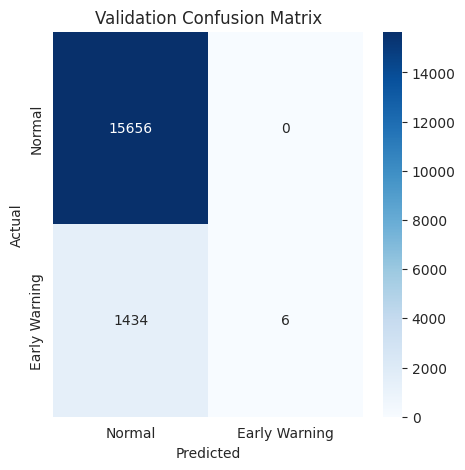

In [37]:
# Predict on validation data and report basic metrics
y_val_pred = (model.predict(X_val) > 0.5).astype(int).flatten()
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_val, y_val_pred, target_names=["Normal", "Early Warning"]))

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Normal", "Early Warning"], yticklabels=["Normal", "Early Warning"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix")
plt.show()


201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9324 - loss: 0.3309
Test loss: 0.7868, accuracy: 0.7577
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
               precision    recall  f1-score   support

       Normal       0.77      0.98      0.86      4970
Early Warning       0.06      0.00      0.01      1440

     accuracy                           0.76      6410
    macro avg       0.41      0.49      0.44      6410
 weighted avg       0.61      0.76      0.67      6410



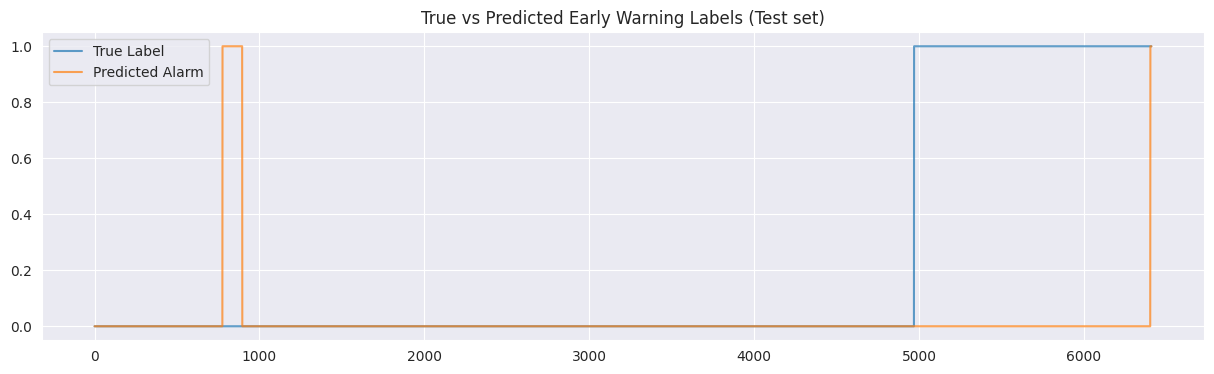

In [33]:
# Evaluate on test set and show performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

y_test_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(classification_report(y_test, y_test_pred, target_names=["Normal", "Early Warning"]))

# Plot a sample of predictions vs. ground truth (for inspection)
plt.figure(figsize=(15,4))
plt.plot(y_test, label="True Label", alpha=0.7)
plt.plot(y_test_pred, label="Predicted Alarm", alpha=0.7)
plt.title("True vs Predicted Early Warning Labels (Test set)")
plt.legend()
plt.show()

# Save model if needed for deployment
model.save("lstm_predictive_maintenance.h5")

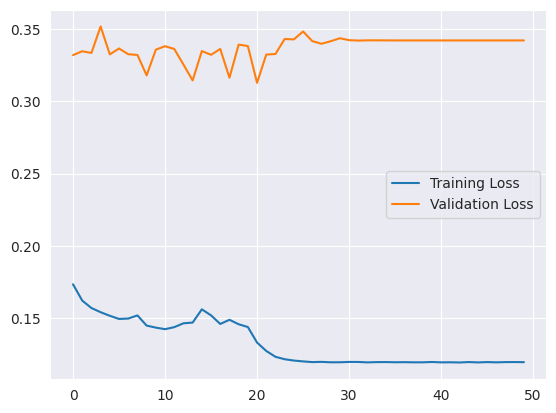

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

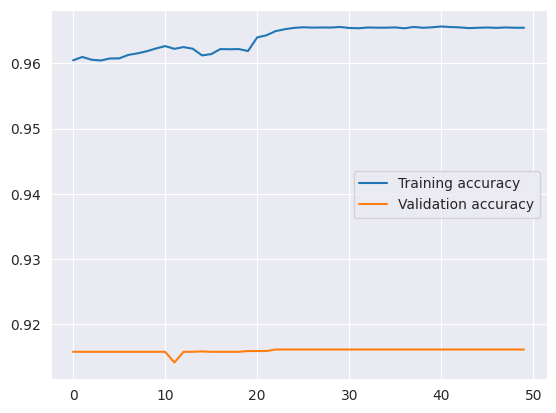

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

/tmp/ipython-input-1214356352.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_lstm["machine_status"] = data_lstm["machine_status"].replace({"BROKEN": 1, "RECOVERING": 1, "NORMAL": 0})


Train samples: (182270, 60, 5), positive ratio=0.040
Val samples:   (17096, 60, 5),   positive ratio=0.084
Test samples:  (6410, 60, 5),  positive ratio=0.225
Class weights: {0: 0.5205632032901125, 1: 12.657638888888888}


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2848/2848 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.7010 - loss: 0.6819 - precision: 0.0526 - recall: 0.3731 - val_accuracy: 0.9158 - val_loss: 0.6473 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
2848/2848 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.5751 - loss: 0.6879 - precision: 0.0457 - recall: 0.4833 - val_accuracy: 0.8208 - val_loss: 0.6613 - val_precision: 0.0049 - val_recall: 0.0056 - learning_rate: 0.0010
Epoch 3/10
2848/2848 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - accuracy: 0.8293 - loss: 0.6468 - precision: 0.0988 - recall: 0.4097 - val_accuracy: 0.8535 - val_loss: 0.5394 - val_precision: 0.0065 - val_recall: 0.0049 - learning_rate: 0.0010
Epoch 4/10
2848/2848 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.8243 - loss: 0.6301 - precision: 0.1004 - recall: 0.4408 - val_accuracy: 0.8638 - val_loss: 0.5064 - val_precision: 0.0088 - val_recall: 0.0056 - learning_rate: 0.0010
Epoch 5/10
2848/2848 ━━━━━━━━━━━━━━

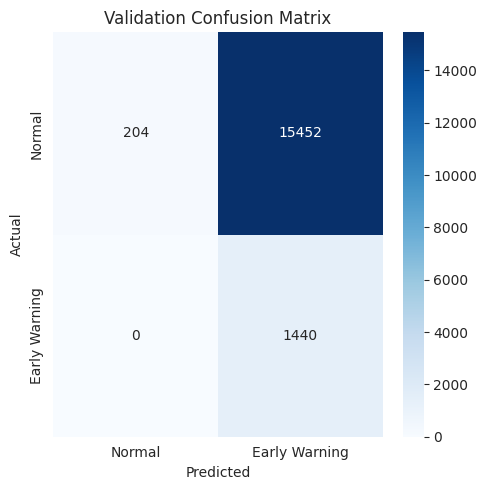

Test -> loss:1.2144 acc:0.2816 recall:0.9382 precision:0.2303

[Test report @ calibrated threshold]
               precision    recall  f1-score   support

       Normal       1.00      0.09      0.17      4970
Early Warning       0.24      1.00      0.39      1440

     accuracy                           0.29      6410
    macro avg       0.62      0.55      0.28      6410
 weighted avg       0.83      0.29      0.22      6410



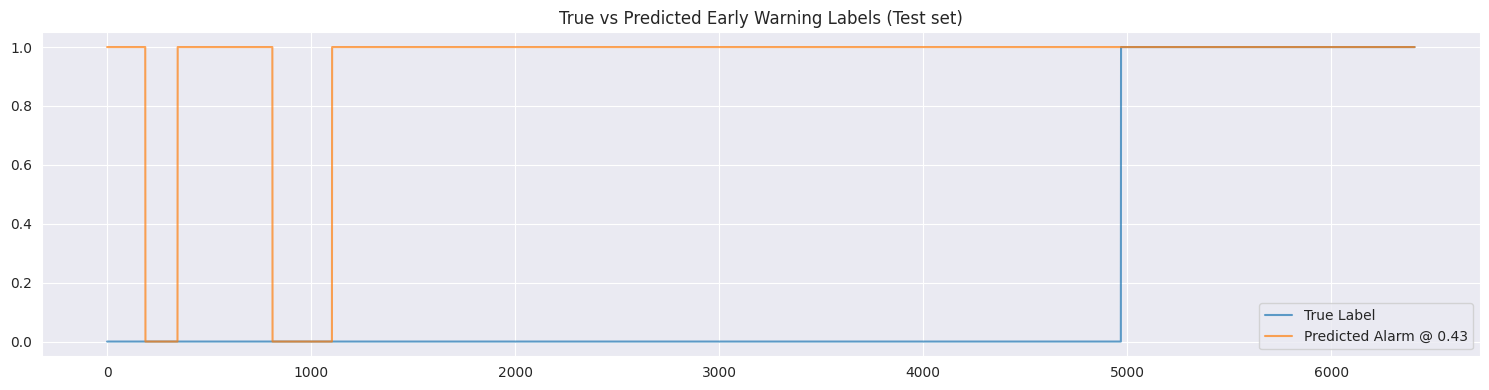

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve, fbeta_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# ---- config ----
top_features = ["sensor_00", "sensor_04", "sensor_06", "sensor_11", "sensor_12"]
window_len, stride = 60, 1

# ---- data prep (keep the status_raw for tracking failures) ----
data_lstm = data[["timestamp", "machine_status"] + top_features].copy()
data_lstm["timestamp"] = pd.to_datetime(data_lstm["timestamp"])
data_lstm.set_index("timestamp", inplace=True)
data_lstm.index = pd.to_datetime(data_lstm.index)

# Keep original raw status for failure events
data_lstm["status_raw"] = data_lstm["machine_status"].astype(str)

# Merge BROKEN and RECOVERING into a single "fault" class (1)
data_lstm["machine_status"] = data_lstm["machine_status"].replace({"BROKEN": 1, "RECOVERING": 1, "NORMAL": 0})

# Interpolate missing sensor data
data_lstm[top_features] = data_lstm[top_features].interpolate(method="linear", limit_direction="both")

# ---- label early-warning (before true BROKEN starts only) ----
def add_alarm_column(df, failure_times, timewindow_for_prediction):
    df = df.copy()
    df["alarm"] = df["machine_status"]
    for ft in failure_times:
        start_pred = ft - pd.Timedelta(minutes=timewindow_for_prediction[0])
        stop_pred  = ft - pd.Timedelta(minutes=timewindow_for_prediction[1])
        start_pred = max(start_pred, df.index.min())
        stop_pred  = max(min(stop_pred, ft), df.index.min())
        df.loc[start_pred:stop_pred, "alarm"] = 2
    return df

# Identify failure events (BROKEN status)
broken_mask = data_lstm["status_raw"].eq("BROKEN")
broken_starts = data_lstm.index[broken_mask & ~broken_mask.shift(1, fill_value=False)]
Failure_times = broken_starts.sort_values()

# Mark 12h..1min before failure as alarm window
data_lstm = add_alarm_column(data_lstm, Failure_times, (24*60, 1))

# ---- split dataset ----
def generate_train_validation_test_datasets(df, Failure_times):
    df_val  = df.loc[:(Failure_times[0] + pd.Timedelta(minutes=120)), :]
    df_test = df.loc[(Failure_times[0] + pd.Timedelta(minutes=120)):(Failure_times[1] + pd.Timedelta(minutes=120)), :]
    df_train= df.loc[(Failure_times[1] + pd.Timedelta(minutes=120)):, :]
    return df_train, df_val, df_test

df_train, df_val, df_test = generate_train_validation_test_datasets(data_lstm, Failure_times)

# ---- scale the sensor data ----
scaler = MinMaxScaler().fit(df_train[top_features])
df_train_scaled = pd.DataFrame(scaler.transform(df_train[top_features]), columns=top_features, index=df_train.index)
df_val_scaled   = pd.DataFrame(scaler.transform(df_val[top_features]),   columns=top_features, index=df_val.index)
df_test_scaled  = pd.DataFrame(scaler.transform(df_test[top_features]),  columns=top_features, index=df_test.index)

# Re-attach labels to scaled data
df_train_scaled["alarm"] = df_train["alarm"].values
df_val_scaled["alarm"]   = df_val["alarm"].values
df_test_scaled["alarm"]  = df_test["alarm"].values

# ---- prepare sequences ----
def build_sequences(df, feature_list, window_len=20, stride=1):
    X, Y = [], []
    labels = df["alarm"].values
    feats  = df[feature_list].values
    for i in range(0, len(df) - window_len, stride):
        end_label = labels[i + window_len - 1]
        if end_label in (0, 2):
            X.append(feats[i:i+window_len])
            Y.append(1 if end_label == 2 else 0)
    return np.asarray(X), np.asarray(Y)

X_train, y_train = build_sequences(df_train_scaled, top_features, window_len, stride)
X_val,   y_val   = build_sequences(df_val_scaled,   top_features, window_len, stride)
X_test,  y_test  = build_sequences(df_test_scaled,  top_features, window_len, stride)

print(f"Train samples: {X_train.shape}, positive ratio={y_train.mean():.3f}")
print(f"Val samples:   {X_val.shape},   positive ratio={y_val.mean():.3f}")
print(f"Test samples:  {X_test.shape},  positive ratio={y_test.mean():.3f}")

# ---- class weights ----
classes = np.array([0, 1])
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = {0: float(cw[0]), 1: float(cw[1])}
print("Class weights:", class_weight)

# ---- LSTM model ----
from tensorflow.keras.metrics import Recall, Precision
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_len, len(top_features))),   # avoid warning
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LeakyReLU(negative_slope=0.2),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.LeakyReLU(negative_slope=0.2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy", Recall(name="recall"), Precision(name="precision")]
)
print(model.summary())

# ---- learning rate scheduler ----
def scheduler(epoch, lr):
    return lr if epoch < 20 else lr * 0.5
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# ---- train with class weights ----
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler],
    shuffle=True,
    class_weight=class_weight
)

# ---- evaluate: returns 4 values (fix unpacking) ----
val_loss, val_acc, val_rec, val_prec = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation -> loss:{val_loss:.4f} acc:{val_acc:.4f} recall:{val_rec:.4f} precision:{val_prec:.4f}")

# ---- calibrate threshold on validation (F2 sweep) ----
val_probs = model.predict(X_val, verbose=0).ravel()
prec_curve, rec_curve, ths = precision_recall_curve(y_val, val_probs)

best_thresh, best_f2 = 0.5, -1.0
for t in ths:
    y_hat = (val_probs >= t).astype(int)
    f2 = fbeta_score(y_val, y_hat, beta=2)
    if f2 > best_f2:
        best_f2, best_thresh = f2, float(t)
print(f"Calibrated threshold (F2-opt): {best_thresh:.4f} | F2={best_f2:.3f}")

# ---- validation report & confusion (use calibrated threshold) ----
y_val_pred = (val_probs >= best_thresh).astype(int)
print("\n[Validation report @ calibrated threshold]")
print(classification_report(y_val, y_val_pred, target_names=["Normal", "Early Warning"]))

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Normal", "Early Warning"], yticklabels=["Normal", "Early Warning"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Validation Confusion Matrix")
plt.tight_layout(); plt.show()

# ---- test evaluation (same unpacking fix; same threshold) ----
test_loss, test_acc, test_rec, test_prec = model.evaluate(X_test, y_test, verbose=0)
print(f"Test -> loss:{test_loss:.4f} acc:{test_acc:.4f} recall:{test_rec:.4f} precision:{test_prec:.4f}")

test_probs = model.predict(X_test, verbose=0).ravel()
y_test_pred = (test_probs >= best_thresh).astype(int)

print("\n[Test report @ calibrated threshold]")
print(classification_report(y_test, y_test_pred, target_names=["Normal", "Early Warning"]))

plt.figure(figsize=(15,4))
plt.plot(y_test, label="True Label", alpha=0.7)
plt.plot(y_test_pred, label=f"Predicted Alarm @ {best_thresh:.2f}", alpha=0.7)
plt.title("True vs Predicted Early Warning Labels (Test set)")
plt.legend(); plt.tight_layout(); plt.show()

# ---- save ----
model.save("lstm_predictive_maintenance.h5")


testing sth

/tmp/ipython-input-4061630574.py:150: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"BROKEN": 1, "RECOVERING": 1, "NORMAL": 0})


Train samples: (7116, 60, 5), pos_ratio=0.250
Val samples:   (17096, 60, 5),   pos_ratio=0.021
Test samples:  (6410, 60, 5),  pos_ratio=0.056


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.6850 - loss: 0.0624 - pr_auc: 0.3727 - precision: 0.3684 - recall: 0.3581 - val_accuracy: 0.9341 - val_loss: 0.0334 - val_pr_auc: 0.0281 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7911 - loss: 0.0563 - pr_auc: 0.5580 - precision: 0.5940 - recall: 0.4830 - val_accuracy: 0.9203 - val_loss: 0.0336 - val_pr_auc: 0.0545 - val_precision: 0.0030 - val_recall: 0.0083 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7854 - loss: 0.0549 - pr_auc: 0.5900 - precision: 0.5707 - recall: 0.5215 - val_accuracy: 0.9115 - val_loss: 0.0313 - val_pr_auc: 0.0605 - val_precision: 0.0043 - val_recall: 0.0139 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8191 - loss: 0.0549 - pr_auc: 0.5860 - precision: 0.6988 - recall: 0.4637 - val_accuracy: 0.9138 - va

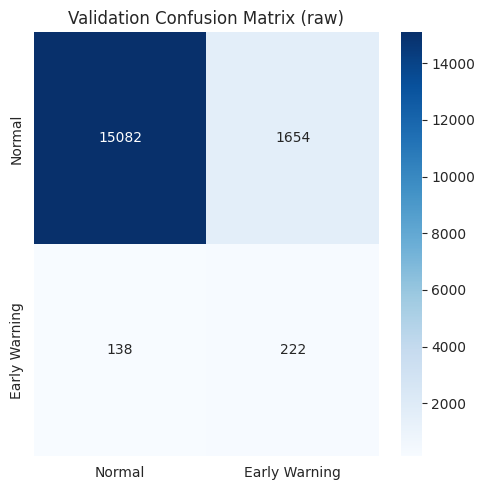

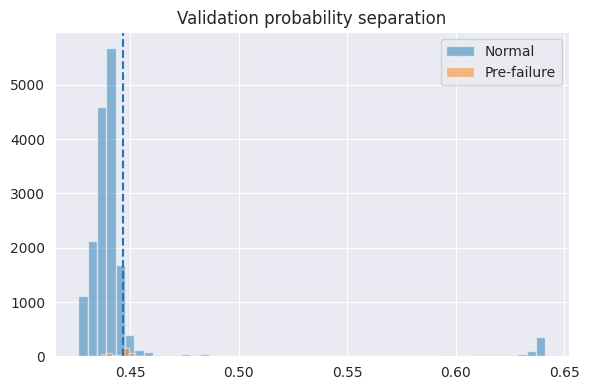


[Test report @ threshold (raw)]
               precision    recall  f1-score   support

       Normal       0.93      0.75      0.83      6050
Early Warning       0.01      0.04      0.02       360

     accuracy                           0.71      6410
    macro avg       0.47      0.40      0.42      6410
 weighted avg       0.88      0.71      0.78      6410


[Test report @ threshold + k-of-n]
               precision    recall  f1-score   support

       Normal       0.93      0.75      0.83      6050
Early Warning       0.01      0.04      0.02       360

     accuracy                           0.71      6410
    macro avg       0.47      0.40      0.42      6410
 weighted avg       0.88      0.71      0.78      6410

Test metrics (raw): acc= 0.708 prec= 0.010 rec= 0.044
Test metrics (+k-of-n): acc= 0.708 prec= 0.010 rec= 0.044
Saved model to lstm_predictive_maintenance.keras


In [ ]:
# ===============================
# LSTM Early-Warning Training (balanced, precision-floor threshold)
# ===============================

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, fbeta_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# -------------------------------
# Reproducibility
# -------------------------------
np.random.seed(42)
tf.random.set_seed(42)

# -------------------------------
# Config
# -------------------------------
top_features = ["sensor_00", "sensor_04", "sensor_06", "sensor_11", "sensor_12"]

# Labels: define early-warning horizon (narrower than before for better precision)
ALARM_WINDOW_MIN = (6 * 60, 1)          # 6h → 1min before failure

# Sequence + sampling
window_len = 60                         # e.g., last 60 minutes if your data is 1/min
stride_pos = 1                          # dense positives
stride_neg = 8                          # sparser negatives
neg_pos_ratio = 3                       # cap negatives to at most 3x positives

# Training
use_focal_loss = True                   # focal loss reduces "spammy" positives; set False to use BCE
batch_size = 64
max_epochs = 50

# Threshold selection
PRECISION_FLOOR = 0.40                  # require at least this precision on validation
BETA_FOR_F = 2.0                        # recall emphasis if PRECISION_FLOOR not reachable

# Optional smoothing of predictions (reduces flicker)
USE_K_OF_N = True
K_OF_N_K, K_OF_N_N = 3, 5

# -------------------------------
# Helpers
# -------------------------------
def focal_loss(alpha=0.75, gamma=2.0):
    """Binary focal loss: emphasizes hard examples."""
    def _f(y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1 - eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        w  = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        return -tf.reduce_mean(w * tf.pow(1 - pt, gamma) * tf.math.log(pt))
    return _f

def add_alarm_column(df, failure_times, timewindow_for_prediction):
    """Mark early-warning interval with alarm=2 (leave others as machine_status)."""
    df = df.copy()
    df["alarm"] = df["machine_status"]
    for ft in failure_times:
        start_pred = ft - pd.Timedelta(minutes=timewindow_for_prediction[0])
        stop_pred  = ft - pd.Timedelta(minutes=timewindow_for_prediction[1])
        start_pred = max(start_pred, df.index.min())
        stop_pred  = max(min(stop_pred, ft), df.index.min())
        df.loc[start_pred:stop_pred, "alarm"] = 2
    return df

def generate_train_validation_test_datasets(df, Failure_times):
    """Time-based split around first two failures; fallback if fewer failures."""
    if len(Failure_times) >= 2:
        df_val  = df.loc[:(Failure_times[0] + pd.Timedelta(minutes=120)), :]
        df_test = df.loc[(Failure_times[0] + pd.Timedelta(minutes=120)):(Failure_times[1] + pd.Timedelta(minutes=120)), :]
        df_train= df.loc[(Failure_times[1] + pd.Timedelta(minutes=120)):, :]
    elif len(Failure_times) == 1:
        # 70/15/15 chronological split if only one failure
        tmin, tmax = df.index.min(), df.index.max()
        t1 = tmin + (tmax - tmin) * 0.70
        t2 = tmin + (tmax - tmin) * 0.85
        df_train = df.loc[:t1, :]
        df_val   = df.loc[t1:t2, :]
        df_test  = df.loc[t2:, :]
    else:
        raise ValueError("No BROKEN events found to define alarm windows.")
    return df_train, df_val, df_test

def build_sequences_balanced(df, feature_list, window_len=60, stride_pos=1, stride_neg=8, neg_pos_ratio=3):
    """
    Build sequences with dense positives (alarm==2) and sparser negatives (alarm==0),
    then cap negatives to a ratio.
    """
    X_pos, Y_pos, X_neg, Y_neg = [], [], [], []
    labels = df["alarm"].values
    feats  = df[feature_list].values
    i = 0
    while i < len(df) - window_len:
        end_label = labels[i + window_len - 1]
        x = feats[i:i + window_len]
        if end_label == 2:                 # early warning → positive
            X_pos.append(x); Y_pos.append(1)
            i += stride_pos
        elif end_label == 0:               # normal → negative
            X_neg.append(x); Y_neg.append(0)
            i += stride_neg
        else:
            i += 1                         # skip BROKEN/RECOVERING ends
    X_pos = np.asarray(X_pos); Y_pos = np.asarray(Y_pos)
    X_neg = np.asarray(X_neg); Y_neg = np.asarray(Y_neg)
    # Cap negatives
    n_pos = len(Y_pos)
    if n_pos == 0:
        raise ValueError("No positive sequences were generated; check alarm window and splits.")
    keep_neg = min(len(Y_neg), neg_pos_ratio * n_pos)
    if keep_neg < len(Y_neg):
        idx = np.random.choice(len(Y_neg), size=keep_neg, replace=False)
        X_neg, Y_neg = X_neg[idx], Y_neg[idx]
    # Concatenate and shuffle
    X = np.concatenate([X_pos, X_neg], axis=0)
    Y = np.concatenate([Y_pos, Y_neg], axis=0)
    p = np.random.permutation(len(Y))
    return X[p], Y[p]

def k_of_n(preds01, k=3, n=5):
    """Require k positives in a sliding window of size n to confirm a positive."""
    kernel = np.ones(n, dtype=int)
    roll = np.convolve(preds01, kernel, mode='same')
    return (roll >= k).astype(int)

# -------------------------------
# Data prep (assumes `data` already loaded)
# -------------------------------
# If you haven't loaded CSV yet, uncomment:
# from google.colab import drive
# drive.mount('/content/drive')
# data = pd.read_csv('/content/drive/MyDrive/datasets/sensor.csv')

data_lstm = data[["timestamp", "machine_status"] + top_features].copy()
data_lstm["timestamp"] = pd.to_datetime(data_lstm["timestamp"])
data_lstm.set_index("timestamp", inplace=True)

# Preserve raw status for detecting exact BROKEN starts
data_lstm["status_raw"] = data_lstm["machine_status"].astype(str)

# Merge BROKEN/RECOVERING → 1 (fault), NORMAL → 0; cast to int to avoid pandas warning
data_lstm["machine_status"] = (
    data_lstm["machine_status"]
    .replace({"BROKEN": 1, "RECOVERING": 1, "NORMAL": 0})
    .astype(int)
)

# Interpolate sensors
data_lstm[top_features] = data_lstm[top_features].interpolate(method="linear", limit_direction="both")

# Failure times (BROKEN onsets only)
broken_mask = data_lstm["status_raw"].eq("BROKEN")
broken_starts = data_lstm.index[broken_mask & ~broken_mask.shift(1, fill_value=False)]
Failure_times = broken_starts.sort_values()

# Label early-warning
data_lstm = add_alarm_column(data_lstm, Failure_times, ALARM_WINDOW_MIN)

# Split
df_train, df_val, df_test = generate_train_validation_test_datasets(data_lstm, Failure_times)

# Scale (fit on train only)
scaler = MinMaxScaler().fit(df_train[top_features])
df_train_scaled = pd.DataFrame(scaler.transform(df_train[top_features]), columns=top_features, index=df_train.index)
df_val_scaled   = pd.DataFrame(scaler.transform(df_val[top_features]),   columns=top_features, index=df_val.index)
df_test_scaled  = pd.DataFrame(scaler.transform(df_test[top_features]),  columns=top_features, index=df_test.index)

# Attach labels
df_train_scaled["alarm"] = df_train["alarm"].values
df_val_scaled["alarm"]   = df_val["alarm"].values
df_test_scaled["alarm"]  = df_test["alarm"].values

# Build balanced sequences
X_train, y_train = build_sequences_balanced(df_train_scaled, top_features,
                                            window_len=window_len,
                                            stride_pos=stride_pos,
                                            stride_neg=stride_neg,
                                            neg_pos_ratio=neg_pos_ratio)
# For val/test, build with stride=1 (no balancing; we evaluate reality)
def build_sequences_eval(df, feature_list, window_len=60, stride=1):
    X, Y = [], []
    labels = df["alarm"].values
    feats  = df[feature_list].values
    for i in range(0, len(df) - window_len, stride):
        end_label = labels[i + window_len - 1]
        if end_label in (0, 2):
            X.append(feats[i:i+window_len])
            Y.append(1 if end_label == 2 else 0)
    return np.asarray(X), np.asarray(Y)

X_val, y_val   = build_sequences_eval(df_val_scaled,   top_features, window_len, stride=1)
X_test, y_test = build_sequences_eval(df_test_scaled,  top_features, window_len, stride=1)

print(f"Train samples: {X_train.shape}, pos_ratio={y_train.mean():.3f}")
print(f"Val samples:   {X_val.shape},   pos_ratio={y_val.mean():.3f}")
print(f"Test samples:  {X_test.shape},  pos_ratio={y_test.mean():.3f}")

# -------------------------------
# Model
# -------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_len, len(top_features))),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LeakyReLU(negative_slope=0.2),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.LeakyReLU(negative_slope=0.2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

metrics = [
    tf.keras.metrics.AUC(curve='PR', name='pr_auc'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.Precision(name='precision'),
    "accuracy"
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=(focal_loss() if use_focal_loss else "binary_crossentropy"),
    metrics=metrics
)

print(model.summary())

# Callbacks: LR schedule + early stopping on PR-AUC
def scheduler(epoch, lr):
    return lr if epoch < 20 else lr * 0.5
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_pr_auc', mode='max', patience=5, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=max_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stop],
    shuffle=True,
    verbose=1
)

# -------------------------------
# Threshold selection on validation
# -------------------------------
val_probs = model.predict(X_val, verbose=0).ravel()
prec, rec, ths = precision_recall_curve(y_val, val_probs)

# Prefer thresholds that meet a precision floor; among them, pick the one with best F2
cands = []
for p, r, t in zip(prec, rec, ths):
    if p >= PRECISION_FLOOR:
        y_hat = (val_probs >= t).astype(int)
        f2 = fbeta_score(y_val, y_hat, beta=BETA_FOR_F)
        cands.append((f2, t, p, r))
if cands:
    cands.sort(reverse=True)   # max F2 first
    best_thresh, best_prec, best_rec = cands[0][1], cands[0][2], cands[0][3]
else:
    # Fall back to pure F2 optimum
    best_thresh, best_f2 = 0.5, -1.0
    for t in ths:
        y_hat = (val_probs >= t).astype(int)
        f2 = fbeta_score(y_val, y_hat, beta=BETA_FOR_F)
        if f2 > best_f2:
            best_f2, best_thresh = f2, float(t)
    # recompute precision/recall at this threshold
    y_hat = (val_probs >= best_thresh).astype(int)
    from sklearn.metrics import precision_score, recall_score
    best_prec = precision_score(y_val, y_hat, zero_division=0)
    best_rec  = recall_score(y_val, y_hat, zero_division=0)

print(f"Chosen threshold: {best_thresh:.4f}  (val precision≈{best_prec:.3f}, recall≈{best_rec:.3f})")

# Reports (validation)
y_val_pred = (val_probs >= best_thresh).astype(int)
if USE_K_OF_N:
    y_val_pred_smooth = k_of_n(y_val_pred, k=K_OF_N_K, n=K_OF_N_N)
else:
    y_val_pred_smooth = y_val_pred

print("\n[Validation report @ threshold (raw)]")
print(classification_report(y_val, y_val_pred, target_names=["Normal", "Early Warning"], zero_division=0))
print("\n[Validation report @ threshold + k-of-n]" if USE_K_OF_N else "")
if USE_K_OF_N:
    print(classification_report(y_val, y_val_pred_smooth, target_names=["Normal", "Early Warning"], zero_division=0))

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Normal", "Early Warning"], yticklabels=["Normal", "Early Warning"])
plt.title("Validation Confusion Matrix (raw)")
plt.tight_layout(); plt.show()

# Probability separation (sanity check)
plt.figure(figsize=(6,4))
plt.hist(val_probs[y_val==0], bins=50, alpha=0.5, label='Normal')
plt.hist(val_probs[y_val==1], bins=50, alpha=0.5, label='Pre-failure')
plt.axvline(best_thresh, linestyle='--')
plt.legend(); plt.title("Validation probability separation"); plt.tight_layout(); plt.show()

# -------------------------------
# Test evaluation (use same threshold)
# -------------------------------
test_probs = model.predict(X_test, verbose=0).ravel()
y_test_pred = (test_probs >= best_thresh).astype(int)
y_test_pred_smooth = k_of_n(y_test_pred, k=K_OF_N_K, n=K_OF_N_N) if USE_K_OF_N else y_test_pred

from sklearn.metrics import accuracy_score, precision_score, recall_score
print("\n[Test report @ threshold (raw)]")
print(classification_report(y_test, y_test_pred, target_names=["Normal", "Early Warning"], zero_division=0))
print("\n[Test report @ threshold + k-of-n]" if USE_K_OF_N else "")
if USE_K_OF_N:
    print(classification_report(y_test, y_test_pred_smooth, target_names=["Normal", "Early Warning"], zero_division=0))

print("Test metrics (raw):",
      "acc=", f"{accuracy_score(y_test, y_test_pred):.3f}",
      "prec=", f"{precision_score(y_test, y_test_pred, zero_division=0):.3f}",
      "rec=", f"{recall_score(y_test, y_test_pred, zero_division=0):.3f}")
if USE_K_OF_N:
    print("Test metrics (+k-of-n):",
          "acc=", f"{accuracy_score(y_test, y_test_pred_smooth):.3f}",
          "prec=", f"{precision_score(y_test, y_test_pred_smooth, zero_division=0):.3f}",
          "rec=", f"{recall_score(y_test, y_test_pred_smooth, zero_division=0):.3f}")

# -------------------------------
# Save model (native Keras format)
# -------------------------------
model.save("lstm_predictive_maintenance.keras")
print("Saved model to lstm_predictive_maintenance.keras")
